## Fraud Detection Model

# The model is implemented to predict the Fraud Transactions from the provided dataset.
# To create the decision model, RandomForestClassifier is used which gives its output on the decision from several features that are considered to be the deciding features for a fraud transaction, such as Incomplete Amount transaction between end-to-end.
# The model gave a good accuracy and F1 score in comparison to the original accuracy provided in the dataset

In [46]:
import pandas as pd

# Importing the Dataset

In [47]:
data=pd.read_csv(r"C:\Codes\Python\Data\Fraud.csv")
data.shape

(1048575, 11)

# Sample data

In [48]:
data.sample(15)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
762538,38,PAYMENT,6374.07,C1983692957,459343.00,452968.93,M1629543337,0.00,0.00,0,0
854355,41,CASH_OUT,194684.78,C1844360843,0.00,0.00,C185783458,1031801.40,1307751.93,0,0
167218,12,CASH_IN,104599.83,C502966576,7022.00,111621.83,C1351026999,0.00,0.00,0,0
128559,11,PAYMENT,10302.02,C1818304108,100848.26,90546.24,M694231451,0.00,0.00,0,0
608381,34,CASH_IN,161692.88,C343099318,1911851.22,2073544.10,C1884155832,422964.95,450034.34,0,0
1009628,46,PAYMENT,2479.68,C1986553115,20508.00,18028.32,M1091165250,0.00,0.00,0,0
438048,18,CASH_OUT,268303.92,C56180022,0.00,0.00,C32794667,313607.04,581910.96,0,0
999104,45,CASH_IN,60491.03,C344584138,8474991.86,8535482.89,C1086872230,169652.71,109161.68,0,0
780613,39,PAYMENT,5880.99,C1065229573,0.00,0.00,M422338472,0.00,0.00,0,0
190231,13,CASH_OUT,79452.44,C828713153,0.00,0.00,C1092136037,572376.59,618375.27,0,0


# Data Description

In [49]:
print(data.describe().apply(lambda s: s.apply('{0:.5f}'.format)))

                step          amount   oldbalanceOrg  newbalanceOrig  \
count  1048575.00000   1048575.00000   1048575.00000   1048575.00000   
mean        26.96617    158666.97553    874009.54435    893808.89803   
std         15.62325    264940.93036   2971750.56005   3008271.33343   
min          1.00000         0.10000         0.00000         0.00000   
25%         15.00000     12149.06500         0.00000         0.00000   
50%         20.00000     76343.33000     16002.00000         0.00000   
75%         39.00000    213761.89000    136642.02000    174599.99000   
max         95.00000  10000000.00000  38900000.00000  38900000.00000   

       oldbalanceDest  newbalanceDest        isFraud isFlaggedFraud  
count   1048575.00000   1048575.00000  1048575.00000  1048575.00000  
mean     978160.04928   1114197.96847        0.00109        0.00000  
std     2296780.39248   2416593.12301        0.03298        0.00000  
min           0.00000         0.00000        0.00000        0.00000  
2

<H3>First Condition, correcting the 'isFlaggedFraud' value by the given condition:
    <Br>"An illegal attempt in this dataset is an attempt to transfer more than 200000 in a single transaction."
<Br>Hence missing data according to condition is Corrected</H3>

In [50]:
data.loc[data["amount"] >= 200000, "isFlaggedFraud"] = 1

# Now, creating different Markers to analyse the different kinds of transactions that happened


<H3><font style="font-family:calibri">This segment answers the 3rd question about selecting the features determining fraud transactions. To predict if a Transaction is fraud, the conditions should be like:<Br>
<p style="margin-left:50px";>1. The Transaction Amount was over the limiting value, i.e. 200000 per transaction.
<Br>2. The amount transferred was not equal to the amount received.
<Br>3. Receiver's Balance altered without any change in the sender's account balance (Defined Fraud-case) and vice-versa.
<Br>4. Sender's account debited without any credit to the Receiver.
</p>
<Br>
Thus, the features to be considered here are:
<p style="margin-left:50px";>1. Original Features: amount, oldbalanceOrg, oldbalanceDest, newbalanceOrig, newbalanceDest, isFlaggedFraud, type
<br>2. Extracted Features: origTransfer, destTransfer, CompleteTransfer, SuccessfullySent, CompleteAmtRecieved. 
</p>
</H3>

<H3>Creating Extracted feature to display the net transaction from both Origin and Destination.</H3>

In [51]:
data['origTransfer']=abs(data.oldbalanceOrg-data.newbalanceOrig)
data['destTransfer']=abs(data.oldbalanceDest-data.newbalanceDest)

<H3>Creating a Flag to mark the transactions that came out to be Complete from end-to-end.</H3>

In [52]:
data['CompleteTransfer'] = 1
data.loc[ (data.origTransfer != data.destTransfer)
          | (data.amount!=data.origTransfer)
          | (data.amount!=data.destTransfer),  'CompleteTransfer'] = 0

data.loc[data.nameDest.str.contains("M", case=False)
         & ((data.amount == data.origTransfer) | (data.amount == data.destTransfer)) , 'CompleteTransfer'] = 1

<H3>Creating a Flag to mark the successfully sent transactions from the Origin-End.</H3>

In [53]:
data['SuccessfullySent'] = 1
data.loc[ (data.amount!=data.origTransfer),  'SuccessfullySent'] = 0

data.loc[data.nameDest.str.contains("M", case=False)
         & (data.amount == data.origTransfer), 'SuccessfullySent'] = 1

<H3>Creating a Flag to mark the successfully recieved transacions from the Reciever-End.</H3>

In [54]:
data['CompleteAmtRecieved'] = 1
data.loc[ (data.amount!=data.destTransfer),  'CompleteAmtRecieved'] = 0

data.loc[data.nameDest.str.contains("M", case=False)
         & (data.amount == data.origTransfer), 'CompleteAmtRecieved'] = 1

<H3>Generating a display for manual check of the Transfers.</H3>

In [55]:
data[['amount','origTransfer','destTransfer','nameDest','CompleteTransfer','SuccessfullySent','CompleteAmtRecieved']]

,amount,origTransfer,destTransfer,nameDest,CompleteTransfer,SuccessfullySent,CompleteAmtRecieved
0,9839.64,9839.64,0.00,M1979787155,0,0,0
1,1864.28,1864.28,0.00,M2044282225,0,0,0
2,181.00,181.00,0.00,C553264065,0,1,0
3,181.00,181.00,21182.00,C38997010,0,1,0
4,11668.14,11668.14,0.00,M1230701703,1,1,1
...,...,...,...,...,...,...,...
1048570,132557.35,132557.35,132557.35,C435674507,0,0,0
1048571,9917.36,9917.36,0.00,M668364942,1,1,1
1048572,14140.05,14140.05,0.00,M1355182933,1,1,1
1048573,10020.05,10020.05,0.00,M1964992463,0,0,0


<H3>Let us now display the Transactions in different segments: Complete, Incomplete (From either Sender or Reciever End) and Frauds-Faulty Transactions. </H3>

<H3>Creating a Dataset out of the Truely-Completed Transactions.

In [56]:
true=data.where(data.CompleteTransfer==1)
true=true.dropna()
true.shape

(59997, 16)

In [57]:
true.sample(7)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origTransfer,destTransfer,CompleteTransfer,SuccessfullySent,CompleteAmtRecieved
636270,35.0,CASH_IN,70615.12,C593965762,19823.00,90438.12,C1268626759,113648.42,43033.30,0.0,0.0,70615.12,70615.12,1.0,1.0,1.0
808192,40.0,PAYMENT,13035.70,C1716877032,20823.00,7787.30,M1754903166,0.00,0.00,0.0,0.0,13035.70,0.00,1.0,1.0,1.0
735571,38.0,PAYMENT,6383.16,C1192618407,10733.00,4349.84,M51890244,0.00,0.00,0.0,0.0,6383.16,0.00,1.0,1.0,1.0
272109,15.0,PAYMENT,16653.60,C1997657608,52885.00,36231.40,M1862372389,0.00,0.00,0.0,0.0,16653.60,0.00,1.0,1.0,1.0
337203,16.0,CASH_OUT,54423.32,C1465008762,81753.00,27329.68,C775886014,0.00,54423.32,0.0,0.0,54423.32,54423.32,1.0,1.0,1.0
554975,22.0,PAYMENT,3102.91,C264836001,7800.21,4697.30,M239365719,0.00,0.00,0.0,0.0,3102.91,0.00,1.0,1.0,1.0
180462,12.0,PAYMENT,20804.14,C609096891,90666.18,69862.04,M973559827,0.00,0.00,0.0,0.0,20804.14,0.00,1.0,1.0,1.0


<H3>Creating a Dataset out of the Successfully Sent Transactions.

In [58]:
sentSuccess=data.where(data.SuccessfullySent==1)
sentSuccess=sentSuccess.dropna()
sentSuccess.shape

(146470, 16)

In [59]:
sentSuccess.sample(7)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origTransfer,destTransfer,CompleteTransfer,SuccessfullySent,CompleteAmtRecieved
949841,44.0,CASH_OUT,91855.65,C1785986997,99774.00,7918.35,C1254117524,0.00,91855.65,0.0,0.0,91855.65,91855.65,1.0,1.0,1.0
480387,19.0,CASH_IN,99702.07,C1632759,10453.00,110155.07,C143580560,3178894.68,3388644.81,0.0,0.0,99702.07,209750.13,0.0,1.0,0.0
785782,39.0,PAYMENT,8163.50,C931695434,704939.99,696776.49,M2036931274,0.00,0.00,0.0,0.0,8163.50,0.00,1.0,1.0,1.0
828573,41.0,CASH_IN,25568.64,C1568435799,47.00,25615.64,C1359266146,0.00,0.00,0.0,0.0,25568.64,0.00,0.0,1.0,0.0
572376,24.0,PAYMENT,5346.32,C1061208664,31488.00,26141.68,M1953279547,0.00,0.00,0.0,0.0,5346.32,0.00,1.0,1.0,1.0
881042,42.0,CASH_IN,299351.41,C2122500202,237.00,299588.41,C115819180,278711.92,0.00,0.0,1.0,299351.41,278711.92,0.0,1.0,0.0
893572,42.0,CASH_IN,103427.06,C870065294,16.00,103443.06,C756112680,0.00,0.00,0.0,0.0,103427.06,0.00,0.0,1.0,0.0


<H3>Creating a Dataset out of the Successfully Recieved Transactions.

In [60]:
recieveSuccess = data.where(data.CompleteAmtRecieved == 1)
recieveSuccess = recieveSuccess.dropna()
recieveSuccess.shape

(164610, 16)

In [61]:
recieveSuccess.sample(7)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origTransfer,destTransfer,CompleteTransfer,SuccessfullySent,CompleteAmtRecieved
220613,14.0,CASH_OUT,59649.16,C781321191,0.00,0.00,C749425091,186452.82,246101.98,0.0,0.0,0.00,59649.16,0.0,0.0,1.0
162155,12.0,PAYMENT,22138.95,C876217766,23064.66,925.71,M1585806333,0.00,0.00,0.0,0.0,22138.95,0.00,1.0,1.0,1.0
191688,13.0,CASH_OUT,52414.56,C1294116918,0.00,0.00,C829366434,111909.40,164323.96,0.0,0.0,0.00,52414.56,0.0,0.0,1.0
225708,14.0,CASH_OUT,336645.26,C744690984,0.00,0.00,C554025243,634632.21,971277.47,0.0,1.0,0.00,336645.26,0.0,0.0,1.0
578780,33.0,CASH_OUT,443230.01,C251667228,10.00,0.00,C732274188,207934.34,651164.35,0.0,1.0,10.00,443230.01,0.0,0.0,1.0
196345,13.0,CASH_OUT,67234.50,C980190779,0.00,0.00,C1761741722,5425393.34,5492627.84,0.0,0.0,0.00,67234.50,0.0,0.0,1.0
840049,41.0,TRANSFER,908464.94,C1249817221,4945.00,0.00,C618781962,0.00,908464.94,0.0,1.0,4945.00,908464.94,0.0,0.0,1.0


<H3>Creating a Dataset out of all other Transactions including Outliers, incomplete or faulty Transactions.

In [62]:
faultyTransfer=data.where((data.CompleteTransfer == 0) & (data.CompleteAmtRecieved == 0) & (data.SuccessfullySent==0))
faultyTransfer=faultyTransfer.dropna()
faultyTransfer.shape

(797492, 16)

In [63]:
faultyTransfer.sample(16)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origTransfer,destTransfer,CompleteTransfer,SuccessfullySent,CompleteAmtRecieved
93043,10.0,CASH_OUT,616512.93,C418371371,136.00,0.00,C1176045015,48847.43,1273014.89,0.0,1.0,136.00,1224167.46,0.0,0.0,0.0
1033716,93.0,TRANSFER,149933.70,C1323147864,0.00,0.00,C1687224917,3991368.34,4141302.04,0.0,0.0,0.00,149933.70,0.0,0.0,0.0
916454,43.0,PAYMENT,3882.60,C163306614,37672.07,33789.47,M464478300,0.00,0.00,0.0,0.0,3882.60,0.00,0.0,0.0,0.0
415191,18.0,CASH_OUT,239293.31,C1206900740,0.00,0.00,C1268199626,457079.65,696372.96,0.0,1.0,0.00,239293.31,0.0,0.0,0.0
299115,15.0,PAYMENT,10887.95,C1950692587,51790.00,40902.05,M2092660756,0.00,0.00,0.0,0.0,10887.95,0.00,0.0,0.0,0.0
54866,9.0,PAYMENT,1239.85,C2037283903,0.00,0.00,M441076603,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0
498846,20.0,CASH_OUT,167459.50,C1093761459,0.00,0.00,C459184199,880144.69,1049432.86,0.0,0.0,0.00,169288.17,0.0,0.0,0.0
705986,37.0,PAYMENT,3887.06,C560441467,117976.54,114089.48,M1149354601,0.00,0.00,0.0,0.0,3887.06,0.00,0.0,0.0,0.0
693469,36.0,CASH_OUT,142793.44,C571466447,0.00,0.00,C1629709129,4472803.10,4615596.55,0.0,0.0,0.00,142793.45,0.0,0.0,0.0
138876,11.0,TRANSFER,714452.90,C1990797183,0.00,0.00,C1446521801,18800000.00,19900000.00,0.0,1.0,0.00,1100000.00,0.0,0.0,0.0


<H3>Since we have to find out the Fraud Transactions out of the dataset, we are not considering the Successfully Completed Transactions.
<bR><BR>Therefore, proceeding with the remaining datasets where Incomplete transactions are made, along the faulty transaction data.

In [64]:
FraudData=data[~data.isin(true)].dropna()
FraudData.shape

(988578, 16)

In [65]:
FraudData.where(FraudData.isFraud==1).dropna().sample(7)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origTransfer,destTransfer,CompleteTransfer,SuccessfullySent,CompleteAmtRecieved
481253,19.0,CASH_OUT,1861008.32,C1718961034,1861008.32,0.0,C714051433,0.00,1789942.62,1.0,1.0,1861008.32,1789942.62,0.0,1.0,0.0
202361,13.0,TRANSFER,1161495.82,C1864459372,1161495.82,0.0,C537531657,0.00,0.00,1.0,1.0,1161495.82,0.00,0.0,1.0,0.0
1030467,66.0,TRANSFER,107188.41,C1876689114,107188.41,0.0,C1824138036,0.00,0.00,1.0,0.0,107188.41,0.00,0.0,1.0,0.0
1027282,48.0,CASH_OUT,5489302.04,C123757418,5489302.04,0.0,C346649476,1356390.81,6845692.85,1.0,1.0,5489302.04,5489302.04,0.0,1.0,0.0
4693,4.0,TRANSFER,13707.11,C17222024,13707.11,0.0,C410033330,0.00,0.00,1.0,0.0,13707.11,0.00,0.0,1.0,0.0
1030297,54.0,TRANSFER,438224.60,C163085808,438224.60,0.0,C652285552,0.00,0.00,1.0,1.0,438224.60,0.00,0.0,1.0,0.0
622611,34.0,TRANSFER,1016540.35,C638438531,1016540.35,0.0,C2146216948,0.00,0.00,1.0,1.0,1016540.35,0.00,0.0,1.0,0.0


<H3>
Current Accuracy of the model based on Provided Data

In [66]:
from sklearn.metrics import accuracy_score
print('accuracy = ',round(accuracy_score(FraudData.isFraud, FraudData.isFlaggedFraud)*100),'%')

accuracy =  72 %


<H3>
    Creating Predictor Model for Fraud data Based on the Data

In [67]:
FraudData.where(FraudData.isFlaggedFraud==1).dropna()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origTransfer,destTransfer,CompleteTransfer,SuccessfullySent,CompleteAmtRecieved
15,1.0,CASH_OUT,229133.94,C905080434,15325.00,0.00,C476402209,5083.00,51513.44,0.0,1.0,15325.00,46430.44,0.0,0.0,0.0
19,1.0,TRANSFER,215310.30,C1670993182,705.00,0.00,C1100439041,22425.00,0.00,0.0,1.0,705.00,22425.00,0.0,0.0,0.0
24,1.0,TRANSFER,311685.89,C1984094095,10835.00,0.00,C932583850,6267.00,2719172.89,0.0,1.0,10835.00,2712905.89,0.0,0.0,0.0
82,1.0,TRANSFER,224606.64,C873175411,0.00,0.00,C766572210,354678.92,0.00,0.0,1.0,0.00,354678.92,0.0,0.0,0.0
84,1.0,TRANSFER,379856.23,C1449772539,0.00,0.00,C1590550415,900180.00,19200000.00,0.0,1.0,0.00,18299820.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048483,95.0,CASH_IN,345998.11,C1864721083,5010.00,351008.11,C2091086284,442981.57,96983.45,0.0,1.0,345998.11,345998.12,0.0,1.0,0.0
1048502,95.0,CASH_OUT,222985.32,C1204350021,0.00,0.00,C308249257,6363300.53,6586285.86,0.0,1.0,0.00,222985.33,0.0,0.0,0.0
1048507,95.0,TRANSFER,476779.24,C1104878203,19992.00,0.00,C1338644402,0.00,476779.24,0.0,1.0,19992.00,476779.24,0.0,0.0,1.0
1048519,95.0,CASH_OUT,271378.96,C1617333943,6268.62,0.00,C1654714274,3538250.81,3809629.77,0.0,1.0,6268.62,271378.96,0.0,0.0,0.0


<H3>
    Create the OneHotEncoder to convert Type from Categorical to Numerical

In [68]:
FraudDataOHE = pd.get_dummies (FraudData['type'], drop_first=True)

In [69]:
FraudData=FraudData.join(FraudDataOHE)
FraudData

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origTransfer,destTransfer,CompleteTransfer,SuccessfullySent,CompleteAmtRecieved,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1.0,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0.0,0.0,9839.64,0.00,0.0,0.0,0.0,0,0,1,0
1,1.0,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0.0,0.0,1864.28,0.00,0.0,0.0,0.0,0,0,1,0
2,1.0,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1.0,0.0,181.00,0.00,0.0,1.0,0.0,0,0,0,1
3,1.0,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1.0,0.0,181.00,21182.00,0.0,1.0,0.0,1,0,0,0
5,1.0,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.00,0.00,0.0,0.0,7817.71,0.00,0.0,0.0,0.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048567,95.0,CASH_OUT,279674.05,C990252469,18002.85,0.00,C574439165,1847488.28,2127162.32,0.0,1.0,18002.85,279674.04,0.0,0.0,0.0,1,0,0,0
1048569,95.0,PAYMENT,3210.11,C2113264897,11113.00,7902.89,M1989479599,0.00,0.00,0.0,0.0,3210.11,0.00,0.0,0.0,0.0,0,0,1,0
1048570,95.0,CASH_OUT,132557.35,C1179511630,479803.00,347245.65,C435674507,484329.37,616886.72,0.0,0.0,132557.35,132557.35,0.0,0.0,0.0,1,0,0,0
1048573,95.0,PAYMENT,10020.05,C1633237354,90605.00,80584.95,M1964992463,0.00,0.00,0.0,0.0,10020.05,0.00,0.0,0.0,0.0,0,0,1,0


<H3>Using Random Forest Classifier as the Fraud Predictor

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

<H3>
    Discarding Unnecessary Columns from Predictor

In [71]:
X = FraudData[['amount','oldbalanceDest','oldbalanceOrg','newbalanceDest','newbalanceOrig','origTransfer','destTransfer', 'CASH_OUT','DEBIT','PAYMENT','TRANSFER']]
Y = FraudData[['isFraud']]

In [72]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y,test_size=0.3)

In [73]:
print(pd.DataFrame(xtrain))

            amount  oldbalanceDest  oldbalanceOrg  newbalanceDest  \
965008      411.88            0.00       10045.00            0.00   
410407    38707.10       261419.87       10103.00       300126.97   
188065   548566.88            0.00       30612.00            0.00   
265557    98243.37       615921.56     2682660.03       723424.67   
502894     5921.65            0.00           0.00            0.00   
...            ...             ...            ...             ...   
1005311   26794.02            0.00           0.00            0.00   
346668   184870.38      3571489.17      115957.00      3756359.55   
117823   849307.19       277376.84        7146.00      1796739.33   
449998   113109.46       155299.37           0.00       268408.82   
399278   666179.91       137809.03       24874.00            0.00   

         newbalanceOrig  origTransfer  destTransfer  CASH_OUT  DEBIT  PAYMENT  \
965008          9633.12        411.88          0.00         0      0        1   
410407   

In [74]:
classifier= RandomForestClassifier(criterion='gini', random_state=0)
classifier.fit(xtrain, ytrain)

C:\Users\Manz\AppData\Local\Temp\ipykernel_2704\1644507227.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(xtrain, ytrain)


RandomForestClassifier(random_state=0)

In [75]:
Y_Pred = classifier.predict(xtest)

<H2><font style="font-family:calibri">Performance Metrics</h2>
    <h3>Analysing the accuracy, f1 score, precision and recall of the Model, it can be considered that it is an efficient model to predict fraud transactions if the necessary parameters are provided.</h3>

In [76]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
print('accuracy = ',round(accuracy_score(ytest, Y_Pred)*100,2),'%')
print('precision = ',round(precision_score(ytest, Y_Pred)*100,2),'%')
print('recall = ',round(recall_score(ytest, Y_Pred)*100,2),'%')
print('f1-score = ',round(f1_score(ytest, Y_Pred)*100,2),'%')
print('roc_auc score = ',round(roc_auc_score(ytest, Y_Pred)*100,2),'%\n\n')

from sklearn.metrics import classification_report
print(classification_report(ytest, Y_Pred))

accuracy =  99.97 %
precision =  95.39 %
recall =  73.14 %
f1-score =  82.8 %
roc_auc score =  86.57 %


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    296291
         1.0       0.95      0.73      0.83       283

    accuracy                           1.00    296574
   macro avg       0.98      0.87      0.91    296574
weighted avg       1.00      1.00      1.00    296574



[[296281     10]
 [    76    207]]


Text(61.0, 0.5, 'Original Fraud')

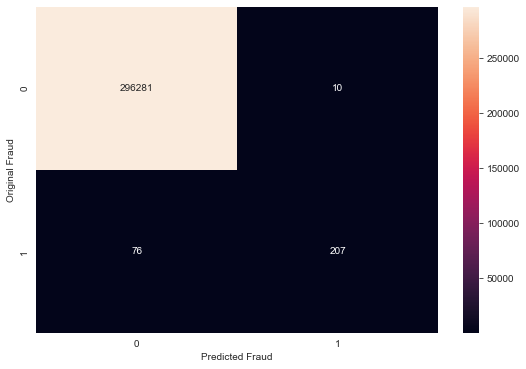

In [77]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(ytest, Y_Pred)
print(cm)
plt.figure(figsize=(9,6))
sns.heatmap(cm,annot=True,fmt= '')
plt.xlabel('Predicted Fraud')
plt.ylabel('Original Fraud')

<H3> As mentioned above, the features that finally are giving out the correct result for the fraudulant transactions are:<br> 'amount','oldbalanceDest','oldbalanceOrg','newbalanceDest','newbalanceOrig','origTransfer','destTransfer', 'type'.
    
<br> These factors determine whether the transaction is fraud or not on the basis of the given conditions such as the limits-per-transaction, end-to-end complete transaction of amounts, etc. the type of transaction is also considered as the isFraud feature is considered when the Fraudulated user cashes out all of the victim's amount, or such, whereas the balance logs play a vital role for checking out of complete transactions.

<H3>Now mapping the prediction on the complete dataset

In [78]:
Fraud_Predict = classifier.predict(X)
Fraud_Predict=pd.DataFrame(Fraud_Predict)

In [79]:
FraudData=FraudData.drop(columns=FraudData[['CASH_OUT','DEBIT','PAYMENT','TRANSFER','origTransfer','destTransfer','CompleteTransfer','SuccessfullySent', 'CompleteAmtRecieved']])

In [80]:
FraudData['NewPredict']=Fraud_Predict
FraudData=FraudData.dropna()

<H3>Displaying Fraud Predicted Samples which were originally flagged as Fraud

In [81]:
FraudData.where((FraudData.NewPredict==1) & ((FraudData.isFraud==1) | (FraudData.isFlaggedFraud==1))).dropna()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,NewPredict
2,1.0,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1.0,0.0,1.0
625,1.0,CASH_IN,219220.21,C811562535,4028495.42,4247715.63,C451111351,1974114.63,3940085.21,0.0,1.0,1.0
4965,5.0,CASH_IN,585796.59,C1982072255,10400000.00,10900000.00,C728526866,5925754.14,5154700.22,0.0,1.0,1.0
6330,6.0,CASH_OUT,517419.65,C945213643,0.00,0.00,C798678484,747686.12,1270287.47,0.0,1.0,1.0
22912,8.0,CASH_OUT,427512.51,C929679144,7600.00,0.00,C357863579,47457.17,222337.44,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
972431,44.0,TRANSFER,408342.01,C345722230,0.00,0.00,C133285043,1561029.84,1969371.85,0.0,1.0,1.0
972435,44.0,TRANSFER,321501.94,C318091875,0.00,0.00,C1629934439,2028390.44,2349892.38,0.0,1.0,1.0
972436,44.0,TRANSFER,1009923.37,C1501352305,0.00,0.00,C1212809725,1210741.07,2220664.44,0.0,1.0,1.0
975111,44.0,CASH_OUT,267598.60,C586215205,0.00,0.00,C644345897,7436067.83,7703666.43,0.0,1.0,1.0


<H3>Displaying Non-Fraud Predicted Samples

In [82]:
FraudData.where(FraudData.NewPredict==0).sample(7)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,NewPredict
741285,38.0,CASH_OUT,282007.99,C1190190079,138.00,0.00,C2134317947,120571.43,402579.43,0.0,1.0,0.0
289337,15.0,CASH_OUT,214732.23,C282488628,21502.00,0.00,C1308125128,370536.25,585268.49,0.0,1.0,0.0
481580,19.0,TRANSFER,175598.25,C639989148,0.00,0.00,C1789142765,516203.14,691801.38,0.0,0.0,0.0
911666,43.0,CASH_IN,250706.28,C1896647072,7126099.88,7376806.16,C1039424113,907420.62,656714.34,0.0,1.0,0.0
281140,15.0,CASH_OUT,38376.54,C96744089,0.00,0.00,C823249274,511941.36,550317.90,0.0,0.0,0.0
721746,37.0,PAYMENT,76832.26,C1085924188,526.00,0.00,M968510231,0.00,0.00,0.0,0.0,0.0
270406,15.0,PAYMENT,2870.94,C1125935115,1245.00,0.00,M1340920681,0.00,0.00,0.0,0.0,0.0


<H3>Displaying Proportion of Frauds in original Dataset

In [83]:
true=true.drop(columns=true[['origTransfer','destTransfer','CompleteTransfer','SuccessfullySent', 'CompleteAmtRecieved']])

In [84]:
FinalData= pd.concat([true, FraudData])

In [85]:
Frauds=FinalData['NewPredict'].value_counts()[1]
Non_Frauds=FinalData['NewPredict'].value_counts()[0]
print('\n\nTotal Fraud Transactions: ',Frauds,' --> ',round(Frauds/(Frauds+Non_Frauds)*100,2),'% of total Transactions')
print('Total Non-Fraud Transactions: ',Non_Frauds,' --> ',round(Non_Frauds/(Frauds+Non_Frauds)*100,2),'% of total Transactions')



Total Fraud Transactions:  768  -->  0.08 % of total Transactions
Total Non-Fraud Transactions:  933484  -->  99.92 % of total Transactions


<H2>Conclusion:</h2>
<H3>To conclude, it can be inferred that the company can reduce the amount of fraud transactions firstly by not allowing any transaction over the limit at a time. It may also analyse the change of data for the Merchant accounts as well in order to keep a check if any merchant is performing frauds or not. The total endpoint transaction should be preserved in order to reduce incomplete transaction with proper monitoring.</h3>

In [86]:
FinalData= pd.concat([true, FraudData])

In [87]:
Frauds=FinalData['NewPredict'].value_counts()[1]
Non_Frauds=FinalData['NewPredict'].value_counts()[0]
print('\n\nTotal Fraud Transactions: ',Frauds,' --> ',round(Frauds/(Frauds+Non_Frauds)*100,2),'% of total Transactions')
print('Total Non-Fraud Transactions: ',Non_Frauds,' --> ',round(Non_Frauds/(Frauds+Non_Frauds)*100,2),'% of total Transactions')



Total Fraud Transactions:  768  -->  0.08 % of total Transactions
Total Non-Fraud Transactions:  933484  -->  99.92 % of total Transactions


<H2>Conclusion:</h2>
<H3>To conclude, it can be inferred that the company can reduce the amount of fraud transactions firstly by not allowing any transaction over the limit at a time. It may also analyse the change of data for the Merchant accounts as well in order to keep a check if any merchant is performing frauds or not. The total endpoint transaction should be preserved in order to reduce incomplete transaction with proper monitoring.</h3>